# Régression non-paramétrique 

**Objectif**

- vérifier l'hypothèse de hazard proportionnel
- régression non-paramétrique et paramétrique
- choisir le meilleur modèle pour chaque


**Tableau.** Notre démarche pour les régressions non-paramétriques.

| Régressions non-paramétriques testées           | **Critère de sélection**            |
|:------------------------------------------------|:------------------------------------|
| - Cox proportionnel                             | - indice de concordance             |
| - Aalen additif                                 | - MAE de prédiction (cross-validée) |
| - Aalen additif avec pénalité (hyper-paramètre) |                                     |

**Tableau.** Notre démarche pour les régressions paramétriques.

| Régressions paramétriques testées       | **Critère de sélection**            |
|:----------------------------------------|:------------------------------------|
| - Weibull AFT                           | - AIC                               |
| - Exponentiel par morceaux (3 morceaux) | - BIC                               |
| - Exponentiel par morceaux (5 morceaux) | - MAE de prédiction (cross-validée) |

In [ ]:
import numpy as np
import pandas as pd
from lifelines import *
from lifelines import (
    AalenAdditiveFitter,
    CoxPHFitter,
    LogNormalAFTFitter,
    PiecewiseExponentialRegressionFitter,
    WeibullAFTFitter,
    WeibullFitter,
)
from lifelines.plotting import qq_plot
from lifelines.utils import find_best_parametric_model, k_fold_cross_validation
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

from src.utils import init_notebook

In [ ]:
init_notebook()

## Données

In [ ]:
df = pd.read_csv(
    "data/kickstarter_1.csv",
    parse_dates=True,
)

In [ ]:
df = df[
    [
        "day_succ",
        "Status",
        "has_video",
        "facebook_connected",
        "goal",
        "facebook_friends",
    ]
]

In [ ]:
event_times = df["day_succ"]
event_observed = df["Status"]

In [ ]:
cph = CoxPHFitter()
cph.fit(df, duration_col="day_succ", event_col="Status")

<lifelines.CoxPHFitter: fitted with 4175 total observations, 2213 right-censored observations>

## Vérification du hazard proportionnel


   Bootstrapping lowess lines. May take a moment...
The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4175 total observations, 2213 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic      p  -log2(p)
facebook_connected km              1.95   0.16      2.63
                   rank            2.88   0.09      3.48
facebook_friends   km              7.22   0.01      7.12
                   rank            5.95   0.01      6.08
goal               km             12.49 <0.005     11.26
                   rank           10.95 <0.005     10.06
has_video          km             19.02 <0.005     16.24
                   rank           20.93 <0.005     17.68



1. Variable 'has_video' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['has_video', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...

   Bootstrapping lowess lines. May take a moment...

2. Variable 'goal' failed the non-proportional test: p-value is 0.0004.

   Advice 1: the functional form of the variable 'goal' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'goal' using pd.cut, and then specify it in `strata=['goal',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May

[[<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0896)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1621)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0009)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0004)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0148)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0072)'>]]

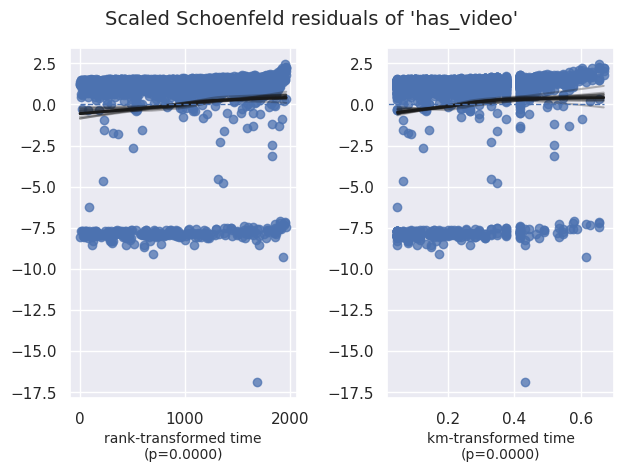

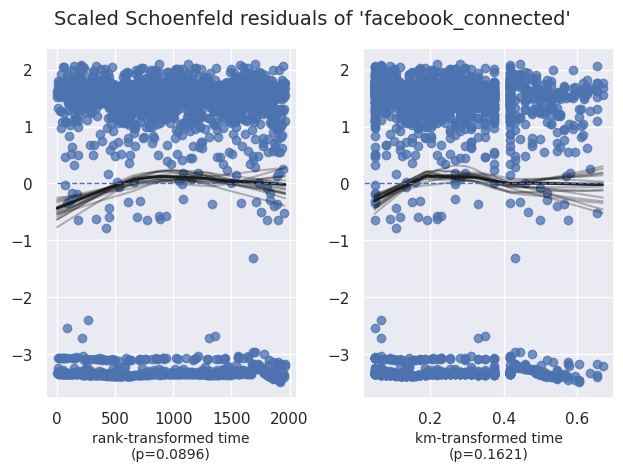

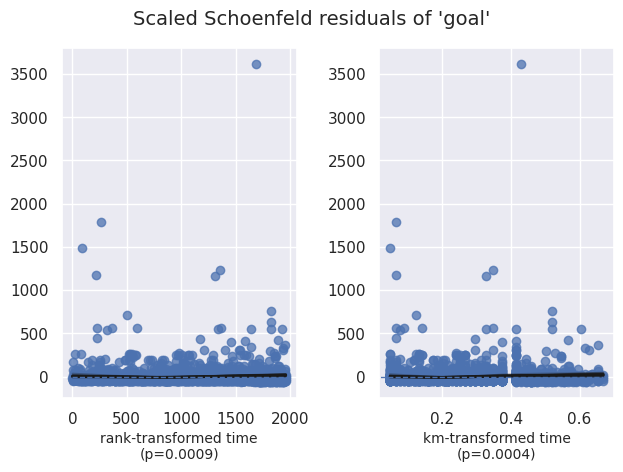

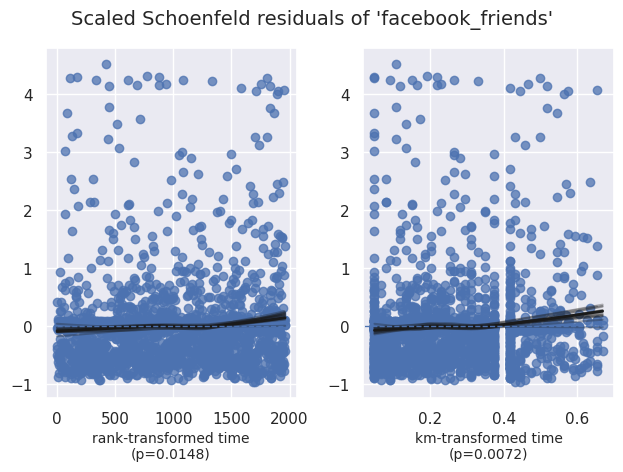

In [ ]:
cph.check_assumptions(df, show_plots=True)

## Modèles non-paramétrique

### Modèle de Cox

In [ ]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3340 total observations, 1771 right-censored observations>
             duration col = 'day_succ'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 3340
number of events observed = 1569
   partial log-likelihood = -11708.02
         time fit was run = 2024-01-15 23:19:26 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
has_video            0.77       2.15       0.08             0.61             0.92                 1.84                 2.51
facebook_connected  -0.04       0.96       0.06            -0.15             0.07                 0.86                 1.08
goal               -21.28       0.00       1.74           -24.70           -17.87                 0.00                 0.00
facebook_friends     0.15       1.16       0.02             0.11             0.20                 1.11                 1.22

                     cmp to      z      p   -log2(p)
covariate                                           
has_video              0.00   9.72 <0.005      71.73
facebook_connected     0.00  -0.64   0.52       0.94
goal                   0.00 -12.21 <0.005     111.42
facebook_friends       0.00   6.73 <0.005      35.79
---
Concordance = 0.66
Partial AIC = 23424.05
log-likelihood ratio test = 409.37 on 4 df
-log2(p) of ll-ratio test = 287.61

<Axes: >

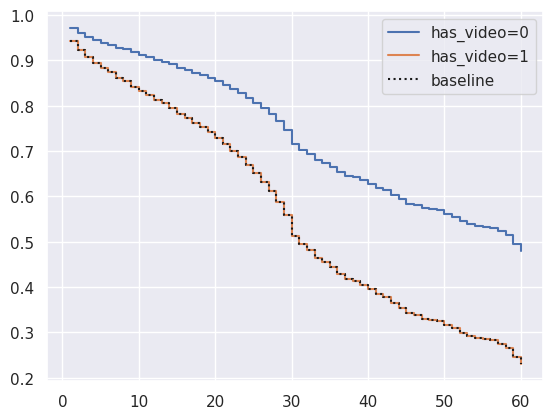

In [ ]:
cph.plot_partial_effects_on_outcome(covariates="has_video", values=[0, 1])

### Cross-validation (Cox & Aalen additif)

In [ ]:
# create the three models we'd like to compare.
aaf_1 = AalenAdditiveFitter(coef_penalizer=0)
aaf_2 = AalenAdditiveFitter(coef_penalizer=10)
cph = CoxPHFitter()

In [ ]:
def moyenne_cross_val(model, df: pd.DataFrame):
    return np.mean(
        k_fold_cross_validation(
            model,
            df,
            duration_col="day_succ",
            event_col="Status",
            scoring_method="concordance_index",
        )
    )

In [ ]:
models_list = {
    "Cox proportionnel": cph,
    "Aalen Additive (sans pénalité)": aaf_1,
    "Aalen Additive (pénalité 10)": aaf_2,
}

cox_tab = {
    "Modèle": [],
    "Indice de concordance": [],
}  # todo: rename

for model in models_list.keys():
    m = models_list[model]
    moy = moyenne_cross_val(m, df)

    cox_tab["Modèle"].append(model)
    cox_tab["Indice de concordance"].append(moy)

In [ ]:
# print(pd.DataFrame(cox_tab).to_markdown(index=False))

**Tableau.** Comparaison des modèles de régression non-paramétriques.

| Modèle                         |   Indice de concordance |
|:-------------------------------|------------------------:|
| Cox proportionnel              |                0.656568 |
| Aalen Additive (sans pénalité) |                0.586883 |
| Aalen Additive (pénalité 10)   |                0.588575 |

Interprétation : 
- indice de concordance **> 0.5** => performance **supérieure** à du hasard
- indice de concordance **= 0.5** => performance **équivalente** à du hasard
- indice de concordance **< 0.5** => performance **inférieure** à du hasard

Choix : **modèle de Cox proportionnel**

## Prédictions

In [ ]:
models_nonparam = {
    "Cox proportionnel": cph,
    "Aalen additif (sans pénalité)": aaf_1,
    "Aalen additif (avec pénalité=10)": aaf_2,
}

models_param = {
    "Weibull AFT": WeibullAFTFitter(),
    "Exponentiel morceaux (3)": PiecewiseExponentialRegressionFitter(
        breakpoints=[9, 21, 29]
    ),
    "Exponentiel morceaux (5)": PiecewiseExponentialRegressionFitter(
        breakpoints=[10, 20, 30, 40, 50]
    ),
}

In [ ]:
res_models = {
    "Modèle": [],
    "AIC": [],
    "BIC": [],
    "MAE": [],
}

In [ ]:
for model_name in models_nonparam.keys():
    model = models_nonparam[model_name]
    model.fit(df, duration_col="day_succ", event_col="Status")

    y_pred = model.predict_expectation(df)
    mae = mean_absolute_error(event_times, y_pred)

    res_models["Modèle"].append(model_name)
    res_models["MAE"].append(mae)
    res_models["AIC"].append(np.nan)
    res_models["BIC"].append(np.nan)

In [ ]:
for model_name in models_param.keys():
    model = models_param[model_name]
    model.fit(df, duration_col="day_succ", event_col="Status")

    y_pred = model.predict_expectation(df)
    mae = mean_absolute_error(event_times, y_pred)

    res_models["Modèle"].append(model_name)
    res_models["MAE"].append(mae)
    res_models["AIC"].append(model.AIC_)
    res_models["BIC"].append(model.BIC_)

/home/ab2/.cache/pypoetry/virtualenvs/kickstarter-project-analysis-ue2DmfIx-py3.10/lib/python3.10/site-packages/lifelines/fitters/__init__.py:2371: ApproximationWarning: Approximating using `predict_survival_function`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/kickstarter-project-analysis-ue2DmfIx-py3.10/lib/python3.10/site-packages/lifelines/fitters/__init__.py:2507: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/home/ab2/.cache/pypoetry/virtualenvs/kickstarter-project-analysis-ue2DmfIx-py3.10/lib/python3.10/site-packages/lifelines/fitters/__init__.py:2371: ApproximationWarning: Approximating using `predict_survival_function`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `

In [ ]:
# print(pd.DataFrame(res_models).to_markdown(index=False))

**Tableau.** Résultats des modèles de régression

| Modèle                           |     AIC |     BIC |          MAE |
|:---------------------------------|--------:|--------:|-------------:|
| Cox proportionnel                |   nan   |   nan   | 13.6055      |
| Aalen additif (sans pénalité)    |   nan   |   nan   | 13.9461      |
| Aalen additif (avec pénalité=10) |   nan   |   nan   | 14.0145      |
| Weibull AFT                      | 19465.7 | 19470.3 |  3.24738e+77 |
| Exponentiel morceaux (3)         | 19127.7 | 19121.1 | 13.0742      |
| Exponentiel morceaux (5)         | 19138.1 | 19128.1 | 13.2367      |


Meilleur modèle : **exponentiel par morceaux (3)**

Nos 3 meilleurs modèles de régression sont :
1) Exponenentiel morceaux (3)
2) Exponentiel morceaux (5)
3) Cox proportionnel